# Project 2

| Name         | PID          | 
|--------------|--------------|
| Peter Murphy | `petermurphy`|
|Joseph McAlister | `josephrm`|
    
We have neither given nor received unauthorized assistance on this assignment. See the course sylabus for details on the Honor Code policy. In particular, sharing lines of solution code is prohibited.

### Team - "Team Name"

In [1]:
# imports used 
import pandas as pd
from bs4 import BeautifulSoup as soup
from bs4 import Tag
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import sklearn.cluster as cl
from sklearn.linear_model import Ridge
import mplcursors # conda install -c conda-forge mplcursors
import requests
import csv 

# Q1 : Qualitative

## Q1.1: Introduction / Initial Problem Statement
Our goal is to find relationships in suicide rates according to country, age demographic, generation, gdp, and year in roughly the past three decades.

Specifically, some questions we think might be interesting to investigate in depth include:
1. What country has the most suicides, or the highest average rate of suicide from year to year?
2. Is there a relationship between generation or age demographic and propensity for suicide?
3. Is there relationship between a country's gdp and rate of suicide?
4. Do the events of a given year have an impact on global or regionally focused suicides?  If so, which years and what kinds of events?
  - Create our own criteria based on findings, if we can, that contribute to the negation of high suicide rates (e.g. high gdp? positive words in the text analysis as well). As the motivation of the Q.

## Q1.2 Data Collection
Our [primary data set](https://www.kaggle.com/russellyates88/suicide-rates-overview-1985-to-2016) taken from Kaggle has sufficient information to examine the first 3 hypotheses, but in order to qualify/quantify information about the events from each year which may provide insights into the cause of change in this data from year to year, country to country, etc., we need to collect more data in the hopes of modelling a sentiment value that we can ascribe to each of the years contained within our first data set.

To gather information about each year from 1985 - 2016, we webscrape the Wikipedia pages for each year, saving each of the notable events (see the attached image) into a dataframe which we can further mine for positive/negative sentiment which may give insight into why some years show a global/regional/isolated increase or decrease in suicide rates from year to year or country to country.

![](img1.png)

We observe that each of the relevant bullet points under the `Events` heading on the webpage is stored in a `<ul>` element that directly follows the `<h3>` tag containing a `<span>` describing the month of the year.  With this in mind, our approach is to find the `<span>` tags corresponding to each month, navigate to the next `<ul>` immediately proceeding that `<span>` and gather the text fields from each constituent `<li>` tag within. 

In [2]:
DATA_ALREADY_COLLECTED = True # a flag which can be used to skip the data collection process

In [3]:
if not DATA_ALREADY_COLLECTED:
    years = range(1985, 2017) # the years that correspond to our master data set
    months = ['January', 'February', 'March', 'April', 'May', 'June', 
              'July', 'August', 'September', 'October', 'November', 'December']
    base_url = "https://en.wikipedia.org/wiki"

    events = pd.DataFrame()   # stores each event  

    for year in years:        # iterate over each year
        print('.', end='')    # hacky loading bar to indicate progress
        url = f"{base_url}/{year}"

        response = requests.get(url)
        if response.status_code != 200:
            print(f"GET failed with response code: {response.status_code}")
            raise

        year_soup = soup(response.text, 'html5lib')

        for month in months:                             # iterate over each month
            span = year_soup.find('span', {'id': month}) # find the corresponding span
            for elem in span.parent.findNext('ul'):      # iterate over each element in the ul tag that follows
                if isinstance(elem, Tag):                # ensure the element is a Tag (not a NavigableString) 
                    # append the contents of the element to the dataframe
                    events = events.append({'year': int(year), 
                                            'month': month, 
                                            'text': elem.get_text().encode('ascii','ignore').decode()}, 
                                           ignore_index=True)
    events = events[['year', 'month', 'text']]            # reorder columns for clarity
    events['year'] = events['year'].astype('int')         # remove annoying decimal
    # save the data and set the flag so this can be skipped in the future
    with open('data/events.csv', 'w') as f:
        f.write(events.to_csv())
        DATA_ALREADY_COLLECTED = True
else: 
    events = pd.read_csv('data/events.csv')
    events = events.drop('Unnamed: 0', axis=1) # drop the excess index column if preloading

events

,year,month,text
0,1985,January,January 1\r\nThe Internet's Domain Name System...
1,1985,January,January 7 Japan Aerospace Exploration Agency ...
2,1985,January,"January 10 Sinclair C5, the world's first mas..."
3,1985,January,January 13 A passenger train plunges into a r...
4,1985,January,January 15 Tancredo Neves is elected presiden...
...,...,...,...
2948,2016,December,"December 19 Andrei Karlov, the Russian ambass..."
2949,2016,December,December 22 A study finds the VSV-EBOV vaccin...
2950,2016,December,December 23 The United Nations Security Counc...
2951,2016,December,December 25 2016 Russian Defence Ministry Tup...


## Q1.3 Data Processing
Next, we want to process and group our data in order to make it easier to analyze our posed questions.

### Q1.3.1 Processing the `Events` Data Set

Beginning with the `events` data set above:
- We clean the data and filter out stop words,
- Tally the number of negative and positive words in each entry using the bag of words approach
  - keep an additional tally of mentions of topical keywords like 'suicide', 'suicidal', etc.
- Add additional measures of sentiment (negative, positive, topical) according to year which we can further join with our primary dataset as needed

In [4]:
# load / define words of negative sentiment
negatives = list(set(open('data/negative.txt').read().split()))
positives = list(set(open('data/positive.txt').read().split()))
stopwords = list(set(open('data/stopwords.txt').read().split()))
keywords = ['suicide', 'suicidal', 'depression'] # define custom topical keywords

def min_max_norm(series):
    return (series - series.min()) / (series.max() - series.min())

# create bag of words/sentiment for each row, 
events_cleaned = events.copy()

# remove unnecessary characters from the text column
events_cleaned['text'] = events_cleaned['text'].apply(lambda t: 
    t.replace(',',' ').replace('.', ' ').replace('\n', ' '))

# store non-stopwords
events_cleaned['bag'] = events_cleaned['text'].apply(lambda w: 
    [w for w in w.lower().split() if w not in stopwords])

# store negative words
events_cleaned['neg_words'] = events_cleaned['bag'].apply(lambda bag: 
    [w for w in bag if w in negatives])

# store positive words
events_cleaned['pos_words'] = events_cleaned['bag'].apply(lambda bag: 
    [w for w in bag if w in positives])

# store topical keywords
events_cleaned['keywords'] = events_cleaned['bag'].apply(lambda bag: 
    [w for w in bag if w in keywords])

# tally number of negatives
events_cleaned['n_neg_words'] = events_cleaned['neg_words'].apply(lambda t: len(t))

# tally number of positives
events_cleaned['n_pos_words'] = events_cleaned['pos_words'].apply(lambda t: len(t))

# tally number of keywords 
events_cleaned['n_keywords'] = events_cleaned['keywords'].apply(lambda t: len(t))

# tally number of total meaningful words
events_cleaned['n_total_words'] = events_cleaned['bag'].apply(lambda t: len(t))

# extract a negative sentiment value 
events_cleaned['neg_sentiment'] = events_cleaned.apply(lambda row: row['n_neg_words']/row['n_total_words'], axis=1)
# normalize neg_sentiment between 0, 1
events_cleaned['neg_sentiment'] = (events_cleaned['neg_sentiment'] - events_cleaned['neg_sentiment'].min()) / (events_cleaned['neg_sentiment'].max() - events_cleaned['neg_sentiment'].min())

# extract a positive sentiment value 
events_cleaned['pos_sentiment'] = events_cleaned.apply(lambda row: row['n_pos_words']/row['n_total_words'], axis=1)
# normalize pos_sentiment between 0, 1
events_cleaned['pos_sentiment'] = (events_cleaned['pos_sentiment'] - events_cleaned['pos_sentiment'].min()) / (events_cleaned['pos_sentiment'].max() - events_cleaned['pos_sentiment'].min())

# extract a topical keyword sentiment value 
events_cleaned['topical_sentiment'] = events_cleaned.apply(lambda row: row['n_keywords']/row['n_total_words'], axis=1)
events_cleaned['topical_sentiment'] = (events_cleaned['topical_sentiment'] - events_cleaned['topical_sentiment'].min()) / (events_cleaned['topical_sentiment'].max() - events_cleaned['topical_sentiment'].min())

events_cleaned.sort_values('pos_sentiment', ascending=False).head()

,year,month,text,bag,neg_words,pos_words,keywords,n_neg_words,n_pos_words,n_keywords,n_total_words,neg_sentiment,pos_sentiment,topical_sentiment
597,1989,November,November 6 The Asia-Pacific Economic Cooperat...,"[november, 6, asia-pacific, economic, cooperat...",[],"[cooperation, established]",[],0,2,0,7,0.000000,1.000000,0.0
1353,1994,July,July 4 Rwandan Patriotic Front troops capture...,"[july, 4, rwandan, patriotic, troops, capture,...",[war],"[patriotic, breakthrough, civil]",[],1,3,0,12,0.291667,0.875000,0.0
1296,1994,January,January 1\r The North American Free Trade Agre...,"[january, 1, north, american, free, trade, agr...",[war],"[free, agreement, established, liberation]",[],1,4,0,17,0.205882,0.823529,0.0
305,1987,October,October 3 The CanadaUnited States Free Trade ...,"[october, 3, canadaunited, states, free, trade...",[],"[free, agreement, agreement]",[],0,3,0,13,0.000000,0.807692,0.0
523,1989,June,June 22 Ireland's first universities establis...,"[june, 22, ireland's, universities, establishe...",[],"[established, independence, open]",[],0,3,0,13,0.000000,0.807692,0.0


By sorting our `cleaned_events` data according to the various sentiments, we can see that our naive heuristic of $$\frac{\texttt{# positive, #negaitve, or #topical}}{\texttt{#total}}$$ appropriately measuress the desired characteristics. 

We can examine the top few entries for each to verify.

#### Q1.3.1.1 Events Tagged With Positive Sentiment
Here we can see that each of the most positively rated events _do_ correspond to good things such as:
- establishment of cooperative pacts, agreements, or institutions (APEC, NAFTA, Irish universities)
- breakthroughs in violent conflicts, peace deals.

However, we can also see some areas where our heuristic missassigns some positive scores for conveniently worded, or outright bland events such as:
- "The Islamic Salvation Army the armed wing of the Islamic Salvation Front agrees in principle to disband in Algeria"
- "The Marshall Islands became an associated state under the Compact of Free Association" 

both of which received positive scores due to language which may be have otherwise been ignored or even penalized given the context.

In [5]:
top5 = events_cleaned.sort_values('pos_sentiment', ascending=False).head(10).drop(
    ['bag', 'month','neg_words','keywords', 'n_pos_words', 'n_keywords', 'n_neg_words', 
     'n_total_words', 'topical_sentiment', 'neg_sentiment'], axis=1)
top5

,year,text,pos_words,pos_sentiment
597,1989,November 6 The Asia-Pacific Economic Cooperat...,"[cooperation, established]",1.000000
1353,1994,July 4 Rwandan Patriotic Front troops capture...,"[patriotic, breakthrough, civil]",0.875000
1296,1994,January 1\r The North American Free Trade Agre...,"[free, agreement, established, liberation]",0.823529
305,1987,October 3 The CanadaUnited States Free Trade ...,"[free, agreement, agreement]",0.807692
523,1989,June 22 Ireland's first universities establis...,"[established, independence, open]",0.807692
1578,1996,September 2 A permanent peace agreement is si...,"[peace, agreement, liberation]",0.807692
2424,2008,January 24 A peace deal is signed in Goma De...,"[peace, deal, democratic]",0.807692
1861,1999,June 5 The Islamic Salvation Army the armed ...,"[salvation, salvation, principle]",0.807692
211,1986,October 21 The Marshall Islands became an ass...,"[compact, free]",0.777778
115,1985,December 8 The South Asian Association for Re...,"[cooperation, established]",0.777778


#### Q1.3.1.2 Events Tagged With Negative Sentiment
Similarly for negative and topically scored entries, we see generally appropriate events such as:
- acts of war, war crimes, and terror
- disasters, protests, massacres, outbreaks
- suicides

In [6]:
top5 = events_cleaned.sort_values('neg_sentiment', ascending=False).head(10).drop(
    ['bag', 'month','pos_words','keywords', 'n_pos_words','n_neg_words','n_keywords', 
     'n_total_words', 'topical_sentiment', 'pos_sentiment'], axis=1)
top5

,year,text,neg_words,neg_sentiment
528,1989,July 6 The Tel AvivJerusalem bus 405 suicide ...,"[suicide, attack, suicide, attack]",1.000000
1039,1992,March 3 Turkey's worst coal mine disaster lea...,"[worst, disaster, dead]",0.954545
2894,2015,December 15 The Islamic Military Counter Terr...,"[terrorism, fight, terrorism]",0.875000
1259,1993,September 27 War in Abkhazia: Fall of Sukhumi...,"[war, accuses, passive]",0.875000
260,1987,May 11 Klaus Barbie goes on trial in Lyon for...,"[trial, war, war]",0.875000
1072,1992,May 17 Protests begin in Bangkok Thailand a...,"[protests, bloody, crackdown]",0.875000
294,1987,August 17 Rudolf Hess is found dead in his ce...,"[dead, prison, suicide, prisoner, complex]",0.795455
245,1987,February 25 Beginning of the Phosphorite War ...,"[war, protest]",0.777778
1831,1999,March 15 In Brussels Belgium the Santer Com...,"[allegations, corruption]",0.777778
698,1990,April 13 Cold War: The Soviet Union apologize...,"[cold, massacre]",0.777778


#### Q1.3.1.3 Events Tagged With Topical Sentiment
Something which immediately stands out to us is the significant overlap in topical and negative keywords, namely 'suicide'.  Only one of the top ten events pertaining to our topical keywords actually covers the context that we are concerned with: "March 24 26 In San Diego 39 Heaven's Gate cultists commit mass suicide at their compound." 

This indicates that our topical classification lacks sufficient context to delineate between suicide and suicide bombings. For the sake of our research questions, want to ensure to distinguish between the two and reserve the right to forego use of the topical score heavily in further analysis because of this overlap. This undesired overlap may also be remediated by increasing the topical keywords to incorporate more events that _do_ pertain to our topic. 

In [7]:
top5 = events_cleaned.sort_values('topical_sentiment', ascending=False).head(10).drop(
    ['bag', 'month','pos_words','neg_words', 'n_pos_words','n_neg_words','n_keywords',
     'n_total_words', 'pos_sentiment', 'neg_sentiment'], axis=1)
top5

,year,text,keywords,topical_sentiment
528,1989,July 6 The Tel AvivJerusalem bus 405 suicide ...,"[suicide, suicide]",1.000000
2403,2007,August 14 Multiple suicide bombings kill 572 ...,[suicide],0.583333
1640,1997,March 24 26 In San Diego 39 Heaven's Gate c...,[suicide],0.538462
2525,2009,October 25 Two suicide attacks in Baghdad Ir...,[suicide],0.538462
2413,2007,November 6 A suicide bomber kills at least fi...,[suicide],0.538462
2888,2015,November 12 Two suicide bombers detonated exp...,[suicide],0.500000
2309,2005,November 9 At least 60 people are killed and ...,[suicide],0.500000
2289,2005,July 7 Four coordinated suicide bombings hit ...,[suicide],0.500000
2284,2005,July 7 Four coordinated suicide bombings hit ...,[suicide],0.500000
2882,2015,October 10 A series of suicide bombings kills...,[suicide],0.466667


### Q1.3.2 Processing the Primary Data Set

The primary dataset is formatted as follows:

In [8]:
raw_data = pd.read_csv('data/suicide_rates_master.csv')
raw_data

,country,year,sex,age,suicides_no,population,suicides/100k pop,country-year,HDI for year,gdp_for_year ($),gdp_per_capita ($),generation
0,Albania,1987,male,15-24 years,21,312900,6.71,Albania1987,NaN,"2,156,624,900",796,Generation X
1,Albania,1987,male,35-54 years,16,308000,5.19,Albania1987,NaN,"2,156,624,900",796,Silent
2,Albania,1987,female,15-24 years,14,289700,4.83,Albania1987,NaN,"2,156,624,900",796,Generation X
3,Albania,1987,male,75+ years,1,21800,4.59,Albania1987,NaN,"2,156,624,900",796,G.I. Generation
4,Albania,1987,male,25-34 years,9,274300,3.28,Albania1987,NaN,"2,156,624,900",796,Boomers
...,...,...,...,...,...,...,...,...,...,...,...,...
27815,Uzbekistan,2014,female,35-54 years,107,3620833,2.96,Uzbekistan2014,0.675,"63,067,077,179",2309,Generation X
27816,Uzbekistan,2014,female,75+ years,9,348465,2.58,Uzbekistan2014,0.675,"63,067,077,179",2309,Silent
27817,Uzbekistan,2014,male,5-14 years,60,2762158,2.17,Uzbekistan2014,0.675,"63,067,077,179",2309,Generation Z
27818,Uzbekistan,2014,female,5-14 years,44,2631600,1.67,Uzbekistan2014,0.675,"63,067,077,179",2309,Generation Z


### Q1.3.1 Processing the Primary Data Set
We assert that other efforts [[1],[2]](#References) have sufficiently researched trends in our main topic of suicide with respect to the `sex` column so we omit for concision.

Additionally, the `country-year` and `HDI` columns can be dropped due to redundancy and lack of sufficinetly complete data, respectively.

In [9]:
data = raw_data.drop(['sex', 'country-year', 'HDI for year'], axis=1)
data

,country,year,age,suicides_no,population,suicides/100k pop,gdp_for_year ($),gdp_per_capita ($),generation
0,Albania,1987,15-24 years,21,312900,6.71,"2,156,624,900",796,Generation X
1,Albania,1987,35-54 years,16,308000,5.19,"2,156,624,900",796,Silent
2,Albania,1987,15-24 years,14,289700,4.83,"2,156,624,900",796,Generation X
3,Albania,1987,75+ years,1,21800,4.59,"2,156,624,900",796,G.I. Generation
4,Albania,1987,25-34 years,9,274300,3.28,"2,156,624,900",796,Boomers
...,...,...,...,...,...,...,...,...,...
27815,Uzbekistan,2014,35-54 years,107,3620833,2.96,"63,067,077,179",2309,Generation X
27816,Uzbekistan,2014,75+ years,9,348465,2.58,"63,067,077,179",2309,Silent
27817,Uzbekistan,2014,5-14 years,60,2762158,2.17,"63,067,077,179",2309,Generation Z
27818,Uzbekistan,2014,5-14 years,44,2631600,1.67,"63,067,077,179",2309,Generation Z


### Q1.3.2.2 Grouping the Reduced Data 
As it stands, our reduced data can now be grouped in various ways which will make it easier for us to examine our posed questions.

The four questions lend themselves to a variety of groupings including:
1. **by country**: to measure cumulative suicides and regional influences
2. **by generation**: to  gauge shared ~~"struggles"~~ that may transcend regional boundaries
3. **by age range**: for similar reasons as above 
4. **by gdp**: to gauge economic influences
5. **by year**: again to measure cumulative suicides and investigate global/broader regional influences based on the `event` data 


In [10]:
data_by_year = data.groupby('year')
data_by_country = data.groupby('country')
data_by_gen = data.groupby('generation')
data_by_age = data.groupby('age')
data_by_gdp_pc = data.groupby('gdp_per_capita ($)') 
events_by_year = events_cleaned.groupby('year')

# Q2 : Quantitative

## Q2.1: Cursory Evaluation of the Data Collected and Organized from Q1

Now that the data is better organized, we can perform some initial visualizations to get a feel for the layout of our data according to our research questions.

1. What country has the most suicides, or the highest average rate of suicide from year to year?
2. Is there a relationship between generation or age demographic and propensity for suicide?
3. Is there relationship between a country's gdp and rate of suicide?
4. Do the events of a given year have an impact on global or regionally focused suicides?  If so, which years and what kinds of events?
  - Create our own criteria based on findings, if we can, that contribute to the negation of high suicide rates (e.g. high gdp? positive words in the text analysis as well). As the motivation of the Q.

### Q2.1.1 - Visualizing the GroupBy Objects
First we will take a look at some of the cumulative totals and mean values for our `groupby` objects.

#### Q2.1.1.1 Suicides by Year
This graph shows the cumulative number of suicides in our data set as well as the mean number of suicides in each country. As the data spans up to some time during 2016, the data for the last year is incomplete, and the graph shows that we should remove this year unless we want some false outliers in later computations.

Additionally, we can see that the cumulative number of suicides per country each year drastically increased 1988-1996 where the value hovered at approximately the same location, only gradually decreasing the past 5 years of available data.

(-0.5, 31.5)

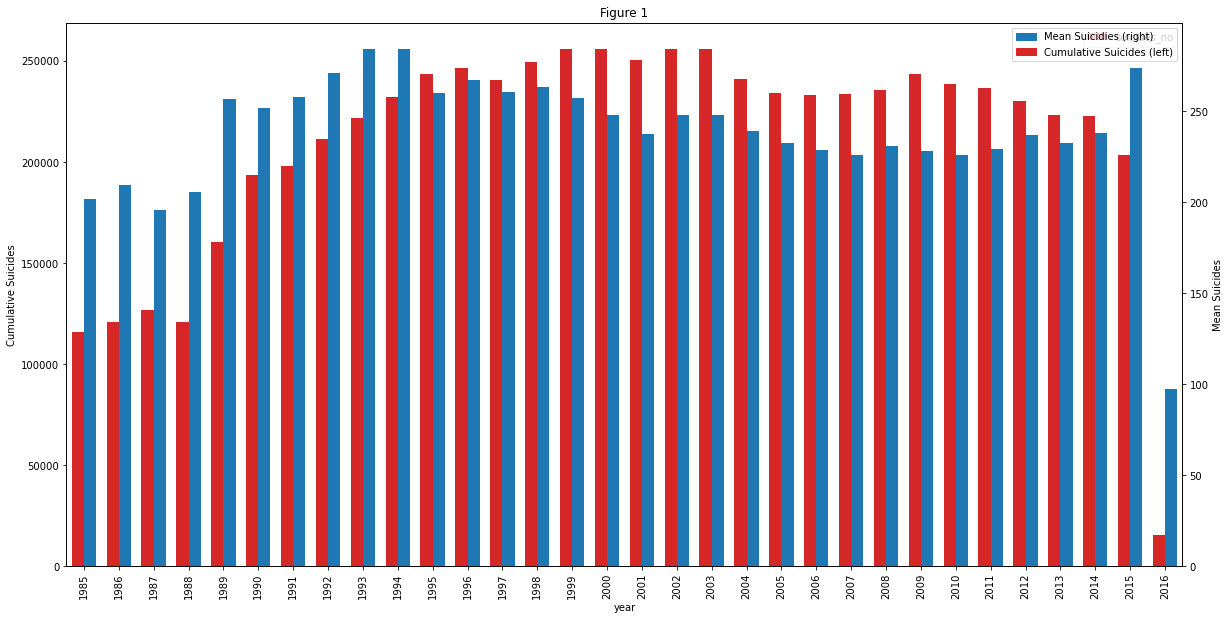

In [11]:
fig, ax = plt.subplots()
plt.title('Figure 1')
ax.set_xlabel('Year')
ax.set_ylabel('Cumulative Suicides')
ax2 = ax.twinx()
ax2.set_ylabel('Mean Suicides')

df_by_year = pd.DataFrame(data_by_year['suicides_no'].sum()) 
df_by_year['year'] = df_by_year.index
df_by_year['mean'] = data_by_year['suicides_no'].mean()

df_by_year.plot.bar(x='year', y='mean', ax=ax2, color='tab:blue', width=0.35, position=0, figsize=(20,10))
df_by_year.plot.bar(x='year', y='suicides_no', ax=ax, color='tab:red', width=0.35, position=1, figsize=(20,10))

colors = {'Mean Suicidies (right)': 'tab:blue', 'Cumulative Suicides (left)': 'tab:red'}
labels = list(colors.keys())
handles = [plt.Rectangle((0, 0), 1, 1, color=colors[label]) for label in labels]
plt.legend(handles, labels)

plt.xlim(-0.5,31.5)

#### Q2.1.1.2  Suicides by Country
The following graph shows the cumulative number of suicides in the range dates for each country. Interestingly, the United States, Japan, and other 1st world European countries are listed near the top. 

Text(0.5, 0, 'Country')

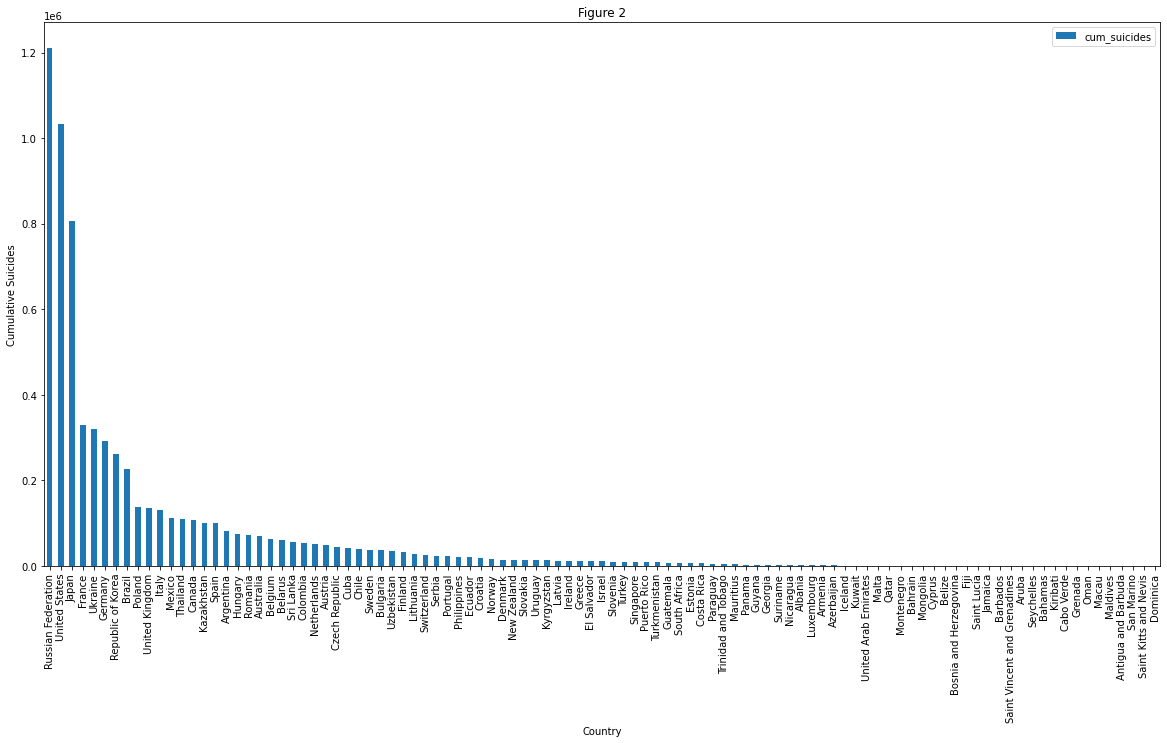

In [12]:
# cumulative suicides by country as a bar chart
fig, ax = plt.subplots()
plt.title('Figure 2')

df_by_country = pd.DataFrame()
df_by_country['cum_suicides'] = data_by_country['suicides_no'].sum()
# min/max normalization
df_by_country['norm_cum_suicides'] = (df_by_country['cum_suicides'] - df_by_country['cum_suicides'].min()) / (df_by_country['cum_suicides'].max() - df_by_country['cum_suicides'].min())
df_by_country = df_by_country.sort_values('cum_suicides', ascending=False)

df_by_country.plot.bar(y='cum_suicides', ax=ax, color='tab:blue', figsize=(20,10))
ax.set_ylabel('Cumulative Suicides')
ax.set_xlabel('Country')

#### Q2.1.1.3 Suicides by Generation
This graph shows the distribution of suicides according to generation.  Here we can see that the Boomer generation bears the most suicides.


| Generation      | Years      |
|-----------------|------------|
| G.I. Generation | 1901 - 1927 |
| Silent | 1928 - 1945 |
| Boomers | 1946 - 1964 |
|Generation X | 1965 - 1990|
|Millenials | 1981 - 1996 |
|Generation Z | 1997 - 2015|

Text(0.5, 0, 'Generation')

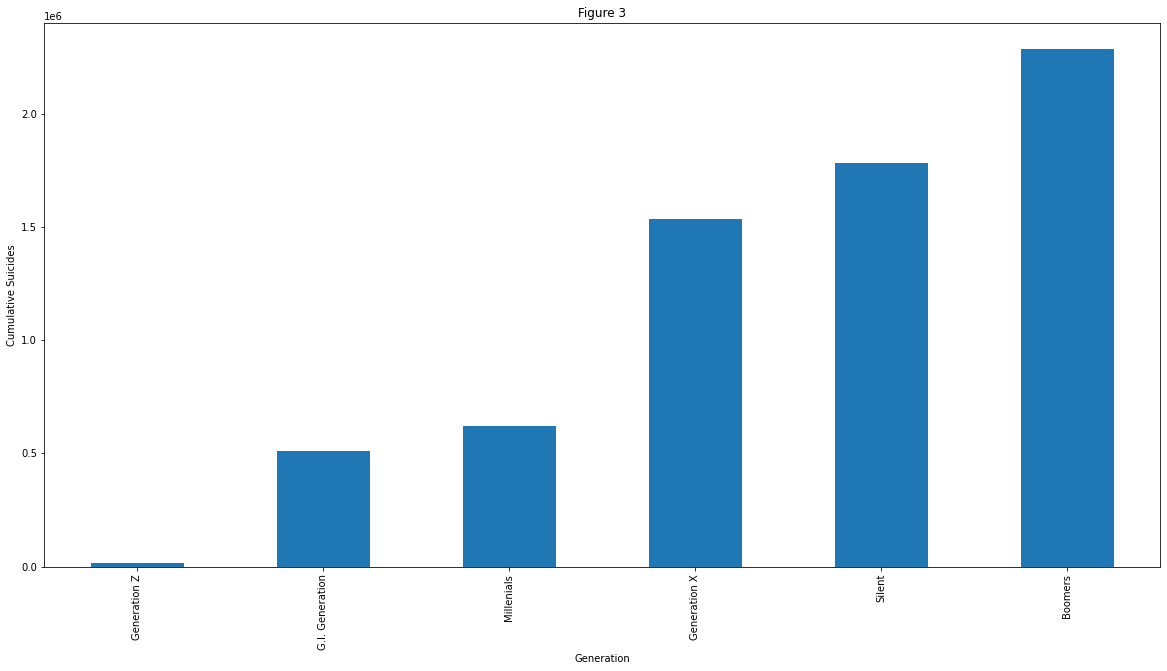

In [13]:
# cumulative suicides by generation
fig, ax = plt.subplots()
plt.title('Figure 3')

df_by_gen = data_by_gen['suicides_no'].sum()
df_by_gen = df_by_gen.sort_values()

df_by_gen.plot.bar('suicides_no', ax=ax, figsize=(20,10))
ax.set_ylabel('Cumulative Suicides')
ax.set_xlabel('Generation')

#### Q2.1.1.4 Suicides by Age Range
Interestingly, this data follows a very similar distribution as the generational data.

Text(0, 0.5, 'Cumulative Suicides')

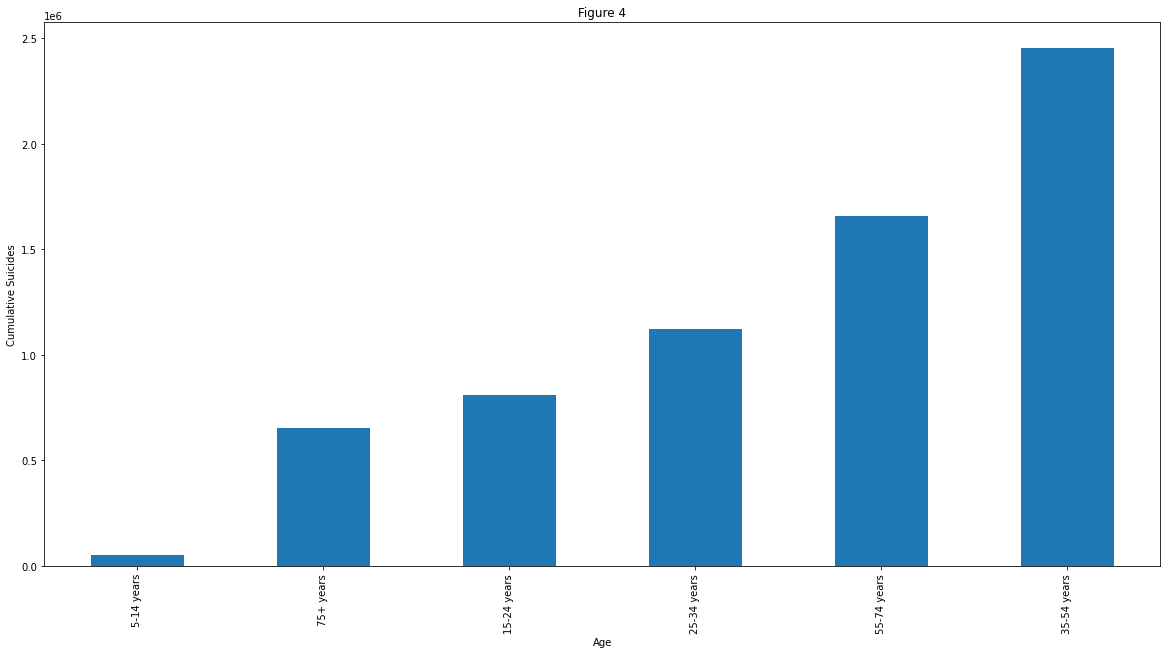

In [14]:
# cumulative suicides by age range
fig, ax = plt.subplots()
plt.title('Figure 4')

df_by_age = data_by_age['suicides_no'].sum()
df_by_age = df_by_age.sort_values()

df_by_age.plot.bar('suicides_no', ax=ax, figsize=(20,10))
ax.set_xlabel('Age')
ax.set_ylabel('Cumulative Suicides')

#### Q2.1.1.5 Suicides by Age Range and Generation
If we overlay the last two graphs, we can see that they are indeed very similar.  With respect to the Boomer generation bearing the brunt of the suicides, perhaps this can be attributed to the fact that they have been alive for the majority of the time range where data was collected.  Additionally, Gen-Z people necessarily belong to the younger age range which have lower number of suicides as shown in the next graph. Moreover it is hard to get a true comparison between generations because this data is only from 1985-2015, if it were over the past 100 years it would be easier to see generational trends. If you think about it, all Millenials and Gen-Z were born after the start of this data set and as seen from the age ranges 0-14 year olds rarely commit suicide. This means it is really hard to see any trends in those generations.

(-0.5, 5.5)

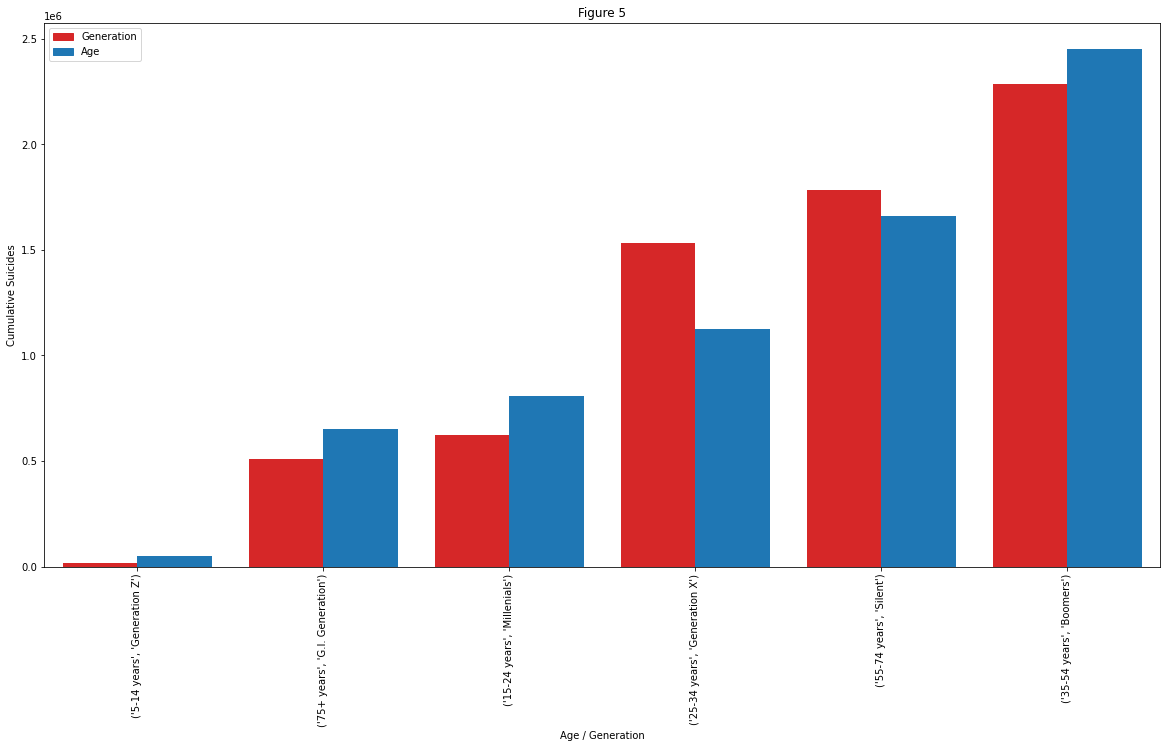

In [15]:
# show the second overlayed onto the first
fig, ax = plt.subplots()
plt.title('Figure 5')

df_by_age = data_by_age['suicides_no'].sum()
df_by_age = df_by_age.sort_values()

df_by_gen.plot.bar(y='suicides_no', ax=ax, width=0.4, position=1, color='tab:red', figsize=(20,10))
df_by_age.plot.bar(y='suicides_no', ax=ax, width=0.4, position=0, color='tab:blue', figsize=(20,10))

ax.set_xlabel('Age / Generation')
ax.set_ylabel('Cumulative Suicides')
colors = {'Generation': 'tab:red', 'Age': 'tab:blue'}
labels = list(colors.keys())
handles = [plt.Rectangle((0, 0), 1, 1, color=colors[label]) for label in labels]
plt.legend(handles, labels)

plt.xticks(np.arange(6), list(zip(df_by_age.index.tolist(), df_by_gen.index.tolist())))
plt.xlim(-0.5,5.5)

#### Q2.1.1.6 Suicides by GDB per Capita
The following scatter plot shows how mean gdp over the date range correllates to the cumulative number of suicides.  Again, here we can see that the Russian Federation, the United States, Japan, France, and Germany are the most obvious outliers. Furthermore, countries with 'ultra high' GDP values on the right side of the graph such as Switzerland, Qatar, and Luxembourg typically have low cumulative suicides, whereas lower GDP countries such as the Ukraine, Brazil, and Poland have higher cumulative suicides, though this does not hold for all low GDP countries which are tightly clustered on the lower lefthand side. 

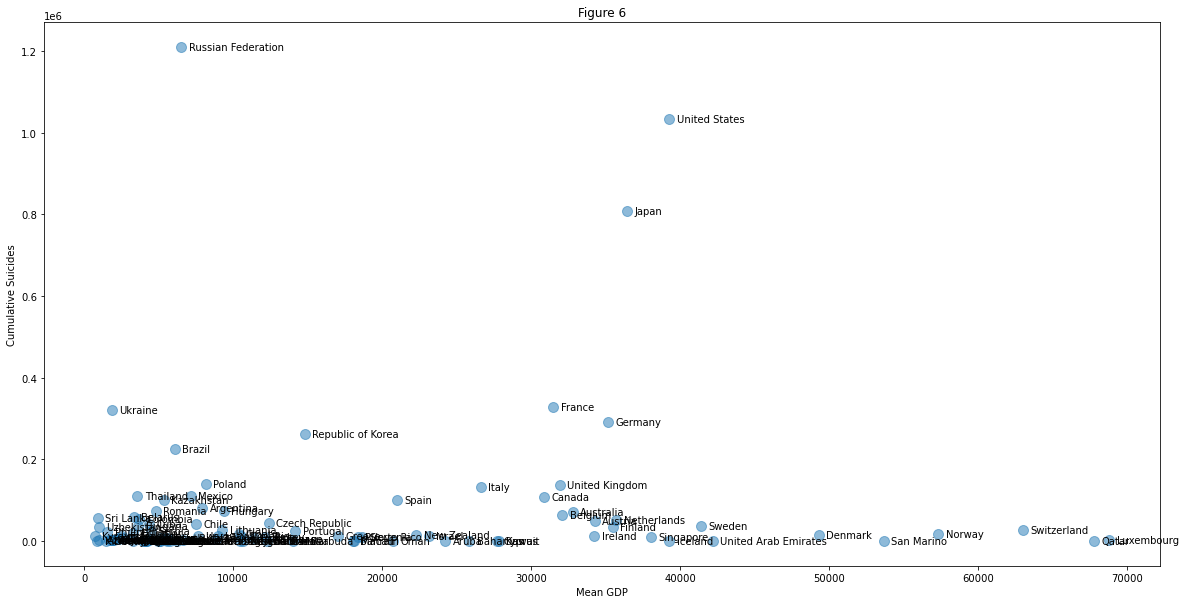

In [16]:
# cumulative suicides by age gdp per capita 
fig, ax = plt.subplots()
plt.title('Figure 6')

df_by_gdp_pc = pd.DataFrame()
df_by_gdp_pc['mean_gdp'] = data_by_country['gdp_per_capita ($)'].mean()
df_by_gdp_pc['cum_suicides'] = data_by_country['suicides_no'].sum()
df_by_gdp_pc = df_by_gdp_pc.sort_values('mean_gdp')
    
df_by_gdp_pc.plot.scatter(x='mean_gdp', y='cum_suicides', ax=ax, s=100, alpha=0.5, figsize=(20,10))
ax.set_ylabel('Cumulative Suicides')
ax.set_xlabel('Mean GDP')

for index, row in df_by_gdp_pc.iterrows():
    row = list(row)
    x, y = row[0], row[1]
    annot = ax.text(x, y, index, ha='left', va='center', position=(x+500,y))


### Q2.1.2 - Visualizing the Event Data
Next we should take a look at our cleaned event data to see what kinds of trends may exist in the given date range. 

#### Q2.1.2.1 Visualizing Positive and Negative Sentiment
First we will simply examine both the positive and negative sentiment calues extracted earlier. We can see that in all cases, the mean negative sentiment is greater than the mean positive sentiment from year to year with the exception of 2006 which was narrowly more positive. 

We can also characterize 2003-2006 as rather milquetoast in terms of positivity, and specifically the year 2004 is bland in terms of both positive _and_ negative sentiment according to our cleaned event data set.

(-0.5, 31.5)

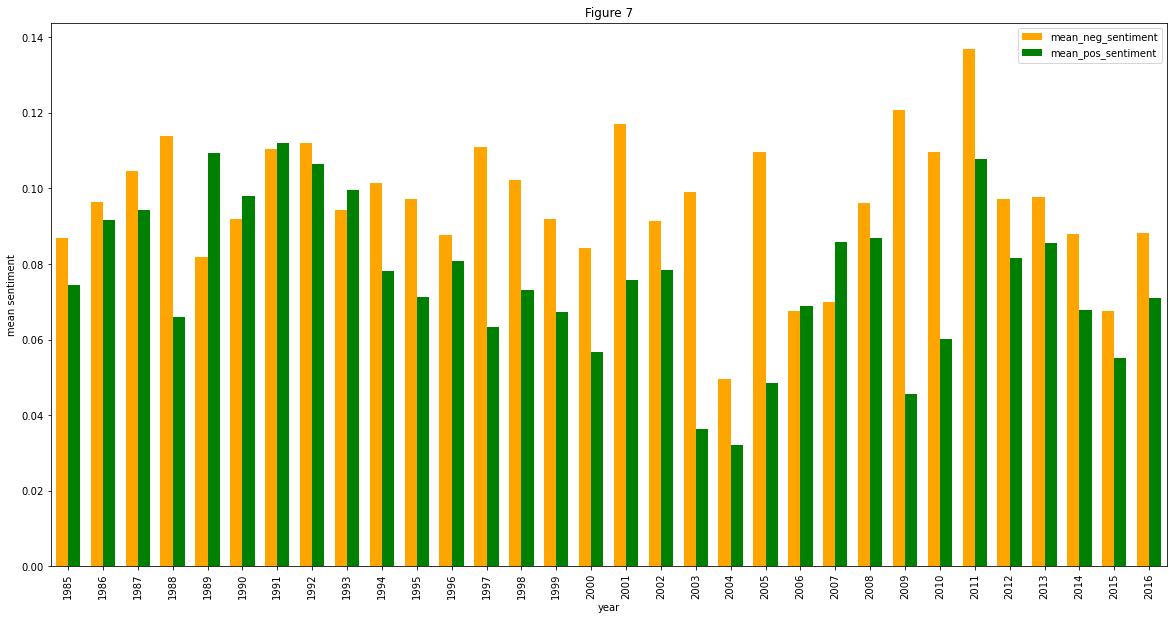

In [17]:
fig, ax = plt.subplots()
plt.title('Figure 7')

df_events_by_year = pd.DataFrame()
df_events_by_year['mean_neg_sentiment'] = events_by_year['neg_sentiment'].mean()
df_events_by_year['mean_pos_sentiment'] = events_by_year['pos_sentiment'].mean()

ax.set_ylabel('mean sentiment')

df_events_by_year.plot.bar(y='mean_neg_sentiment', ax=ax, width=0.35, position=1, color='orange', figsize=(20,10))
df_events_by_year.plot.bar(y='mean_pos_sentiment', ax=ax, width=0.35, position=0, color='green', figsize=(20,10))
plt.xlim(-0.5,31.5)

#### Q2.1.2.2 Comparing Sentiment to Cumulative Deaths
Next we might want to compare specifically the negative sentiment to the number of cumulative deaths per year to see if our sentiment values are a good indicator for our primary data set.  Again here we can see that our primary data set is incomplete for the year 2016 whereas our freshly scraped event data is not.

We can also see that our mean negative sentiment correlates to the aforementioned increase in cumulative suicides from 1988 - 1996 at least for the first four years of drastic increase.

(-0.5, 31.5)

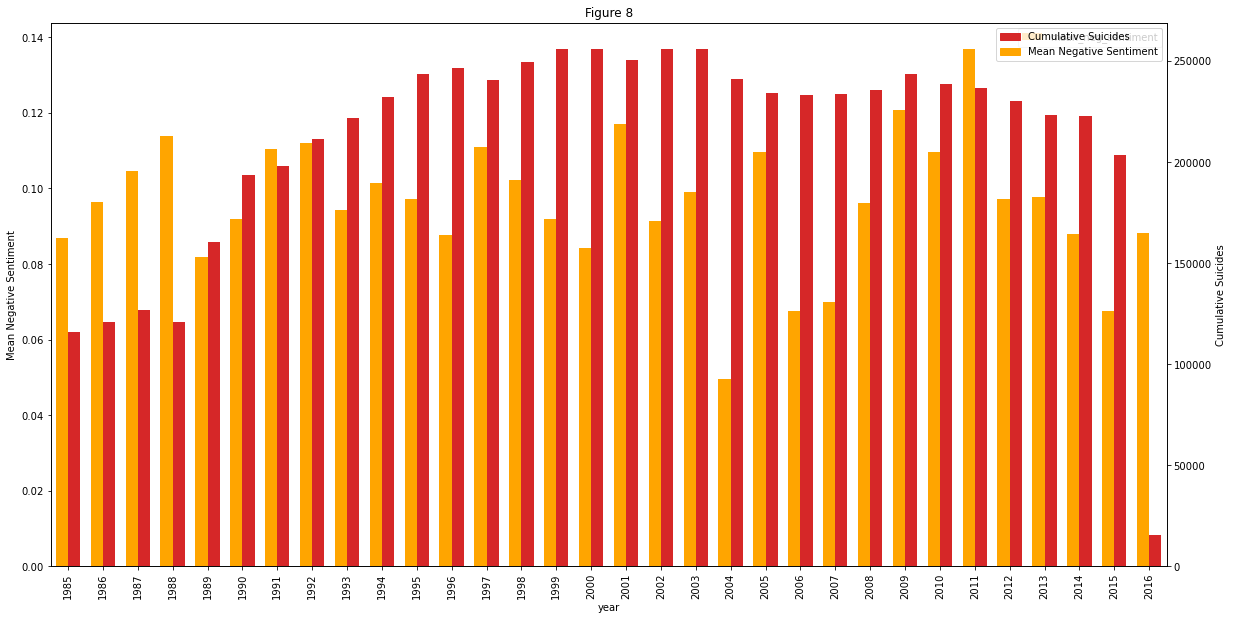

In [18]:
%matplotlib inline
fig, ax = plt.subplots()
plt.title('Figure 8')

ax.set_xlabel('Year')
ax.set_ylabel('Mean Negative Sentiment')

ax2 = ax.twinx()
ax2.set_ylabel('Cumulative Suicides')

df_events_by_year.plot.bar(y='mean_neg_sentiment', ax=ax, width=0.35, position=1, color='orange', figsize=(20,10))
df_by_year.plot.bar(y='suicides_no', ax=ax2, color='tab:red', width=0.35, position=0, figsize=(20,10))

colors = {'Cumulative Suicides': 'tab:red', 'Mean Negative Sentiment': 'orange'}
labels = list(colors.keys())
handles = [plt.Rectangle((0, 0), 1, 1, color=colors[label]) for label in labels]
plt.legend(handles, labels)

plt.xlim(-0.5,31.5)

## Q2.2 Analyzing the Visual Trends

Now that we've taken a preliminary glance at our data, we can refine our initial hypotheses accordingly for a more intellgent approach towards investigating their truth.

### Q2.2.1 Year 
_What country has the most suicides, or the highest average rate of suicide from year to year?_

Immediately we can see that the Russian Federation, the United States, and Japan have the highest rate of suicide as demonstrated by the large margin shown in Figure 1.

In order to characterize the similarities between these countries, it makes sense to develop more granular graphs for some of the possible pairings.  For example, 
- could the Cold War (in very broad terms) have an impact on the United States' and Russian Federation's high cumulative suicides?
- are there any similarities between Japan on the other Asiatic countries? 

#### Q2.2.1.1 Year: Comparing the Russian Federation to the United States

The following graph shows that, though the fall of the Soviet Union made this data available, the trends from year to year are fairly dissimilar with the Russian Federation having an initial increase that steadily fell after the turn of the century whereas the United States has been increasing for the past two decades.

(-0.5, 30.5)

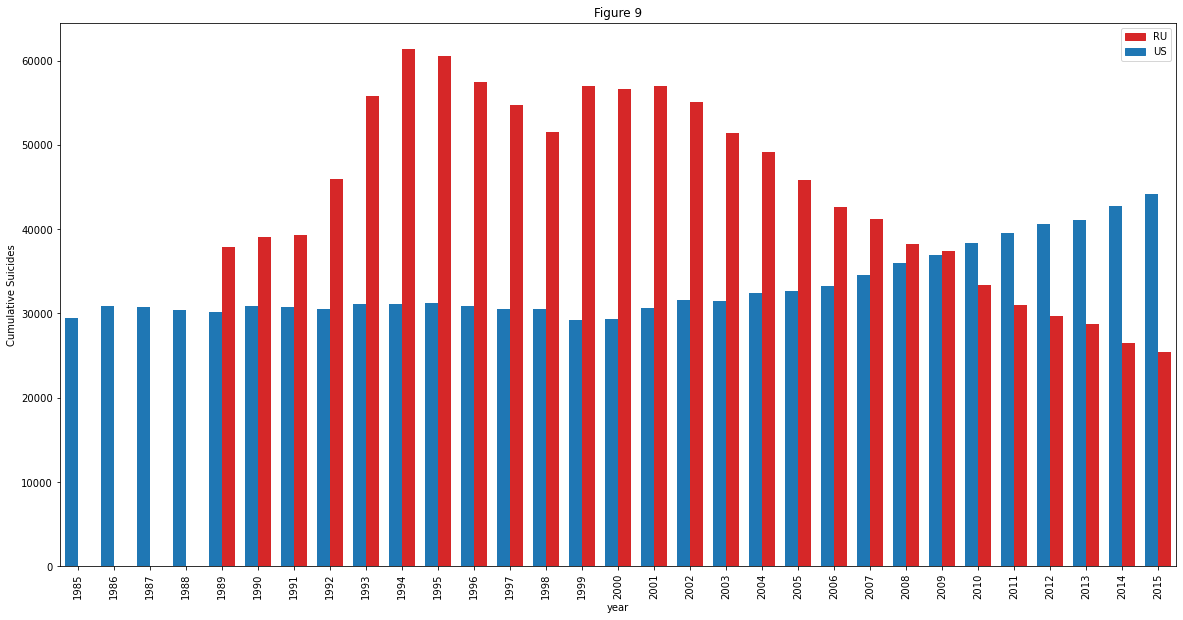

In [19]:
# comparison between Russia and the United States
fig, ax = plt.subplots()
plt.title('Figure 9')
ax.set_xlabel('year')
ax.set_ylabel('Cumulative Suicides')

df_US_RU = pd.DataFrame(data_by_country) 
df_US_RU.index = df_US_RU[0]

df_US = pd.DataFrame(df_US_RU.loc['United States'][1])
df_US = pd.DataFrame(df_US.groupby('year')['suicides_no'].sum()).rename(columns={"suicides_no": 'US'})

df_RU = pd.DataFrame(df_US_RU.loc['Russian Federation'][1])
df_RU = pd.DataFrame(df_RU.groupby('year')['suicides_no'].sum()).rename(columns={"suicides_no": 'RU'})
df_joined = df_US.join(df_RU)
# df_joined
df_joined['US'].plot.bar(ax=ax, color='tab:blue', position=1, width=0.35, figsize=(20,10))
df_joined['RU'].plot.bar(ax=ax, color='tab:red', position=0, width=0.35)

colors = {'RU': 'tab:red', 'US': 'tab:blue'}
labels = list(colors.keys())
handles = [plt.Rectangle((0, 0), 1, 1, color=colors[label]) for label in labels]
plt.legend(handles, labels)

plt.xlim(-0.5,30.5)

## Q2.2.1.1 Year: Comparing Japan to Other Asiatic Countries

In order to attempt to gain insight into why Japan is an outlier, we can render a similar plot comparing the cumulative suicides by year for Japan and some of its neighboring countries (as best we can given it's an island).

(-0.5, 30.5)

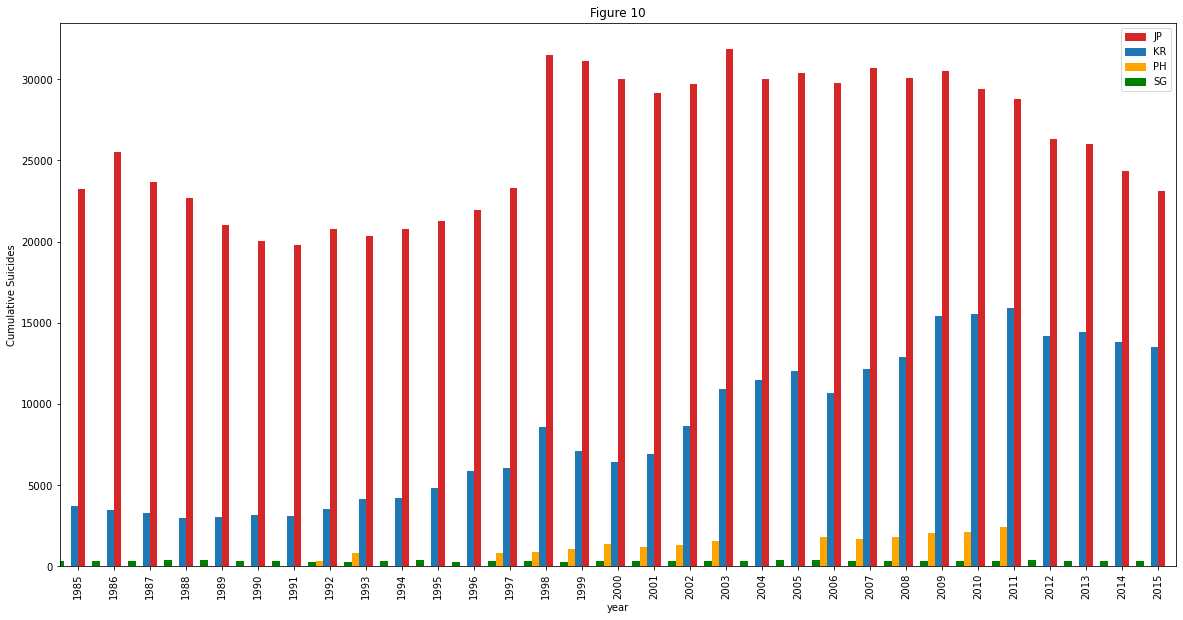

In [20]:
# comparison between Japan and neighboring countries
fig, ax = plt.subplots()
plt.title('Figure 10')
ax.set_xlabel('year')
ax.set_ylabel('Cumulative Suicides')

df_Asiatic = pd.DataFrame(data_by_country) 
df_Asiatic.index = df_Asiatic[0]

df_JP = pd.DataFrame(df_Asiatic.loc['Japan'][1])
df_JP = pd.DataFrame(df_JP.groupby('year')['suicides_no'].sum()).rename(columns={"suicides_no": 'JP'})

df_KR = pd.DataFrame(df_Asiatic.loc['Republic of Korea'][1])
df_KR = pd.DataFrame(df_KR.groupby('year')['suicides_no'].sum()).rename(columns={"suicides_no": 'KR'})

df_PH = pd.DataFrame(df_Asiatic.loc['Philippines'][1])
df_PH = pd.DataFrame(df_PH.groupby('year')['suicides_no'].sum()).rename(columns={"suicides_no": 'PH'})

df_SG = pd.DataFrame(df_Asiatic.loc['Singapore'][1])
df_SG = pd.DataFrame(df_SG.groupby('year')['suicides_no'].sum()).rename(columns={"suicides_no": 'SG'})

df_joined = df_JP.join(df_KR).join(df_PH).join(df_SG)
df_joined
df_joined['JP'].plot.bar(ax=ax, color='tab:red', position=0, width=0.2, figsize=(20,10))
df_joined['KR'].plot.bar(ax=ax, color='tab:blue', position=1, width=0.2)
df_joined['PH'].plot.bar(ax=ax, color='orange', position=2, width=0.2)
df_joined['SG'].plot.bar(ax=ax, color='green', position=3, width=0.2)

colors = {'JP': 'tab:red', 'KR': 'tab:blue', 'PH': 'orange', 'SG': 'green'}
labels = list(colors.keys())
handles = [plt.Rectangle((0, 0), 1, 1, color=colors[label]) for label in labels]
plt.legend(handles, labels)

plt.xlim(-0.5,30.5)

Due to the limited or consistently low numbers for Singapore and the Philippines, no similarities immediately stand out.  However, the Republic of Korea appears to follow the same trends as Japan. Interestingly enough, there is no data in our primary data set for China.  However, Beijing's Health Bureau spokesman Mao Yu has been quoted as saying "Our nation has one of the highest rates of suicide in the world" [[3]](#References). The data is likely available to some extent, but not included in our primary data set.

With respect to Japan's abnormal suicide rate, the BBC cites Wataru Nishida, a psychologist at Tokyo's Temple University, in explaining the "Japan's long tradition of 'honourable suicide' as a reason for the high rate here," along with financial pressures, isolating technologies, and other culutral factors such as the lack of a religious stigma against suicide as potential causes for this abnormality [[4]](#References).

### Q2.2.2 Age/Generation 
_Is there a relationship between generation or age demographic and propensity for suicide?_

As we saw in Figure 5, there is a strong relationship between the generation and the number of cumulative suicides.  Though we are still unsure as to why this relationship exists, we hope to devote a portion of our Q3 submission into further investigating this relationship.

### Q2.2.3 GDP 
_Is there relationship between a country's gdp and rate of suicide?_

Here we want to examine how GPD plays a role on suicide rates. To go about this we have grouped all countries by their mean GDP and their total suicides. From there we will create cluster groups and try to examine any trends. After that we will do some regression analysis to see if we can predict suicides based on this data.

In [21]:
# clustering based on GDP 
km = cl.KMeans(n_clusters=5)
labels = km.fit_predict(df_by_gdp_pc)
df_by_gdp_pc['CID'] = labels
df_by_gdp_pc

,mean_gdp,cum_suicides,CID
country,,,
Kyrgyzstan,720.730769,13090,2
Kiribati,875.909091,53,2
Sri Lanka,904.272727,55641,0
Uzbekistan,976.181818,34803,2
Azerbaijan,1005.125000,1656,2
...,...,...,...
San Marino,53663.666667,4,2
Norway,57319.600000,16992,2
Switzerland,62981.761905,26217,2


The result of this clustering exercise, Figure 10, is displayed in the last cell of the notebook in ordert to allow for interactivity

### Q2.2.4 Events 

_Do the events of a given year have an impact on global or regionally focused suicides?  If so, which years and what kinds of events?_
  
As we saw in Q1.3.1.1-2, events regarding disaster, war, and death, were some of the largest contributos  to high negative sentiment values, and events pertaining to cooperation and peace were loosely correlated to positive sentiment. 

Additionally, Figure 8 showed that in several cases, the mean negative sentiment of a year corresponded to the cumulative number of suicides in a given year as well. We can further examine this relationship using a polynomial regression model

In [22]:
# Build a regression model to predict cumulative suicides based on mean_negative sentiment
df_events_by_year['year'] = df_events_by_year.index
x = pd.DataFrame(df_events_by_year[:-1]['mean_neg_sentiment'], columns=['mean_neg_sentiment']) # drop year 2016
y = pd.DataFrame(df_by_year[:-1]['suicides_no'], columns=['suicides_no'])

coefs = np.polyfit(x.values.flatten(), y.values.flatten(), 8)
suicides_pred = pd.DataFrame(np.polyval(coefs, np.linspace(x.min(), x.max(), 31).reshape(-1, 1)), columns=['suicides_pred'])
# suicides_pred
suicides_pred.index = df_events_by_year[:-1].index
df_event_model = x.join(y).join(suicides_pred)
df_event_model['year'] = df_events_by_year[:-1].index
df_event_model['error'] = abs(df_event_model['suicides_no'] - df_event_model['suicides_pred'])
df_event_model

,mean_neg_sentiment,suicides_no,suicides_pred,year,error
year,,,,,
1985,0.086925,116063,240821.309319,1985,124758.309319
1986,0.096387,120670,91616.206236,1986,29053.793764
1987,0.104620,126842,81107.792713,1987,45734.207287
1988,0.113882,121026,123141.219857,1988,2115.219857
1989,0.081769,160244,171404.789523,1989,11160.789523
1990,0.091879,193361,205624.511062,1990,12263.511062
1991,0.110548,198020,221201.511309,1991,23181.511309
1992,0.111924,211473,221734.429767,1992,10261.429767
1993,0.094394,221565,213913.491911,1993,7651.508089


(-0.9, 31.9)

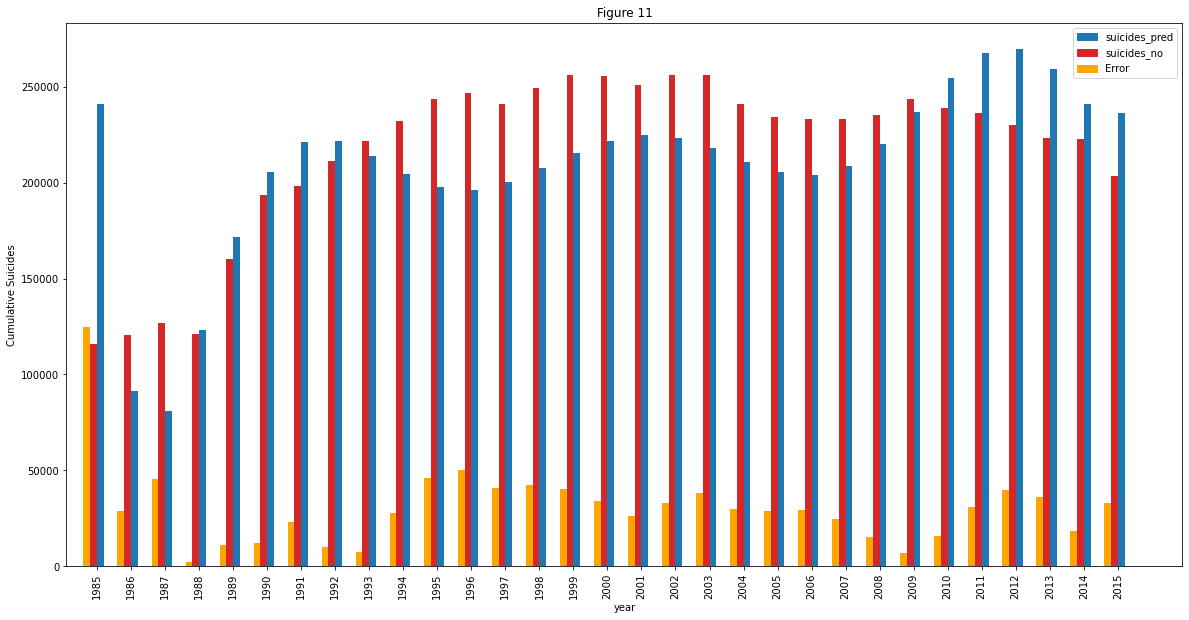

In [23]:
# Visualizing the regression model
fig, ax = plt.subplots()
plt.title('Figure 11')
ax.set_xlabel('Year')
ax.set_ylabel('Cumulative Suicides')
# ax2 = ax.twinx()

df_event_model.plot.bar(x='year', y='suicides_pred', ax=ax, color='tab:blue', width=0.2, position=0, figsize=(20,10))
df_event_model.plot.bar(x='year', y='suicides_no', ax=ax, color='tab:red', width=0.2, position=1)
df_event_model.plot.bar(x='year', y='error', ax=ax, color='orange', width=0.2, position=2)
# df_event_model.plot.bar(x='year', y='mean_neg_sentiment', ax=ax2, color='green', width=0.2, position=3)

colors = {'suicides_pred': 'tab:blue', 'suicides_no': 'tab:red', 'Error': 'orange', } #'sentiment': 'green'}
labels = list(colors.keys())
handles = [plt.Rectangle((0, 0), 1, 1, color=colors[label]) for label in labels]
plt.legend(handles, labels)

plt.xlim(-0.9,31.9)

As we can see from the above graph, the mean negative sentiment is a weak predictor of the cumulative suicides with the exceptions of a few year ranges where the mean negative sentiment was highly correlated to the cumulative suicides including 1988 - 1993/4, 2001 - 2009. 

We could use a similar regression approach to attempt to predict cumulative suicides for similar countries such as the Republic of Korea and Japan.

## Q2 Conclusion

After digging deeper into the data collected and organized in Q1, we are able to answer several of the hypotheses we initially presented.  In Q3, we hope to better organize the presentation of the work completed so far and dig deeper into some of the remaining questions including:

- The relationship between generation or age demographic and propensity for suicide.
- Do the events of a given year have an impact on global or regionally focused suicides? If so, which years and what kinds of events?

as well as further develop our own criteria based on findings. 

# References
[1] The World Health Organization, [Suicide in the world: Global Health Estimates (booklet)](https://www.who.int/mental_health/prevention/suicide/suicideprevent/en/)

[2] American Foundation for Suicide Prevention, https://afsp.org/suicide-statistics/

[3] "China's suicide rate 'among highest in world,'" Asia One, 2009? https://www.asiaone.com/health/chinas-suicide-rate-among-highest-world

[4] "Why does Japan have such a high suicide rate?" Wingfield-Hayes, Rupert. BBC News, 2015. https://www.bbc.com/news/world-33362387

### Credits:
| Task | Peter | Joseph | Part 1 | Part 2 |
|------|-------|--------|--------|--------|
| Brainstorming broad topic/general ideation | x | x | x |  | 
| idea to put together year in review + sentiment analysis | x | x | x |  |
| Researching primary data set | x | x | x |  |
| Webscraping for secondary event data set | x |  | x |  |
| Drafting the report | x |  x | x |  |
| Revising, editing the report | |  x | x |  |
| Visualizing the `groupby` objects | x | | | x |
| Writing explanations for all the graphs | x | x | | x |
| Clustering of countries based on GDP and suicides | | x | | x |
| Interactive clustering graph | x | | | x |
| Regression model for events | x | | | x |

<IPython.core.display.Javascript object>


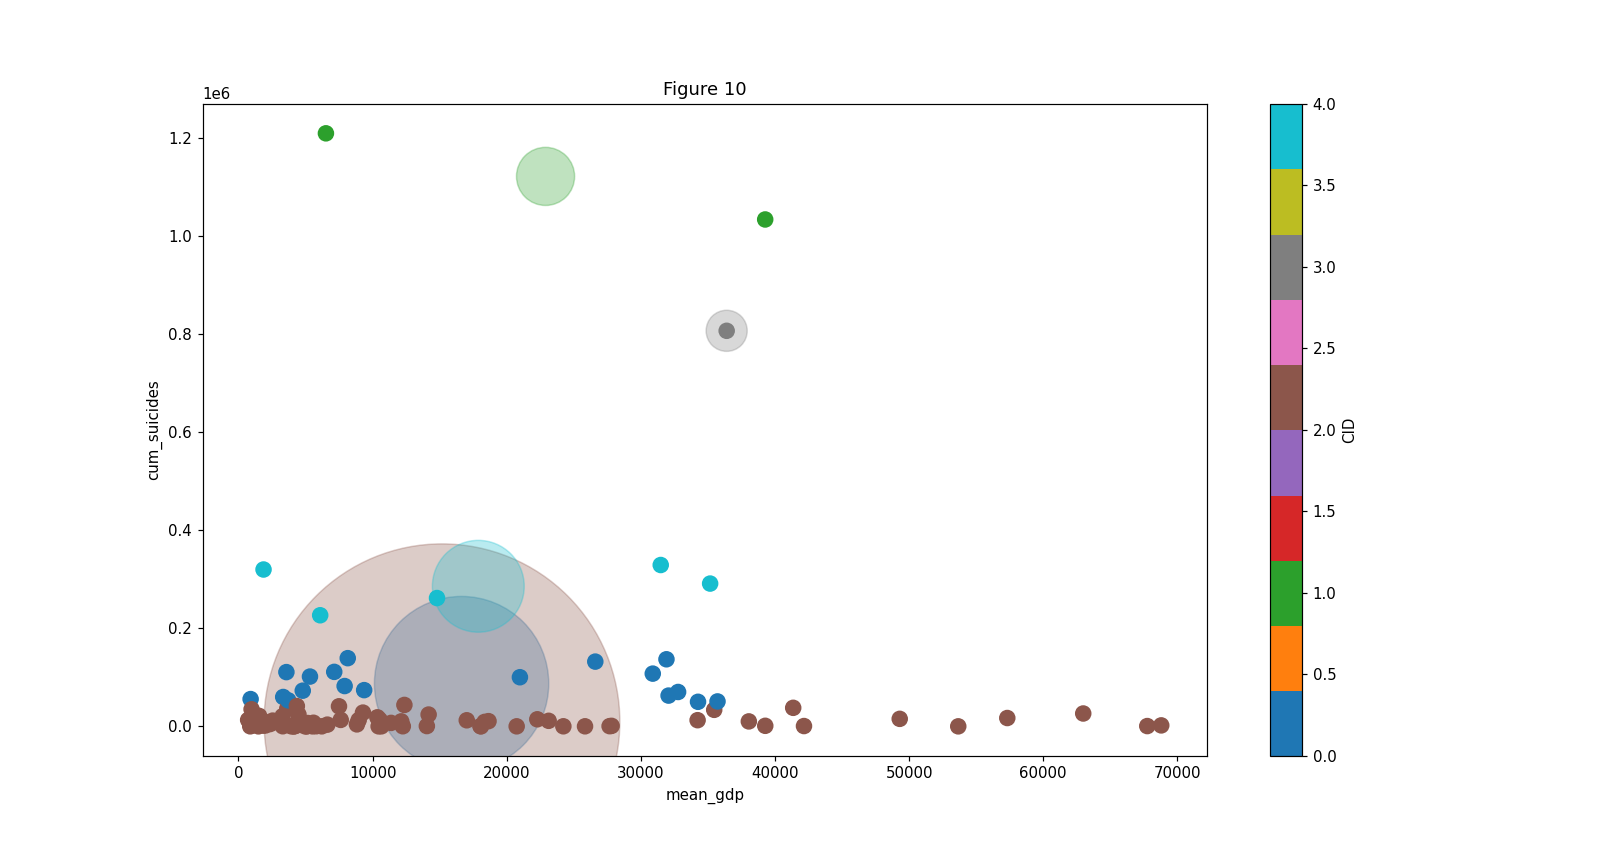

<function __main__.<lambda>(sel)>

In [25]:
# this needs to be the last cell to run otherwise it breaks other plots by switching from `inline` to `notebook`
# it also may need to be executed twice in order to display the graph
# Due to the fact that the canvas indexes all the object on the canvas, the centroids are incorrectly labeled
#   However, the rest of the actual country data points are correct
%matplotlib notebook

fig, ax = plt.subplots()
plt.title('Figure 10')

centers = df_by_gdp_pc.groupby('CID').mean()
sizes = [np.array([df_by_gdp_pc.CID == i]).sum()*750 for i in range(df_by_gdp_pc.CID.nunique())]
colors = centers.index.tolist()
centers.plot.scatter(x='mean_gdp', y='cum_suicides', c=colors, cmap='tab10', s=sizes, alpha=0.3, ax=ax, figsize=(15,8))
df_by_gdp_pc.plot.scatter(x='mean_gdp', y='cum_suicides', c='CID', cmap='tab10', s=100, ax=ax)

crs = mplcursors.cursor(ax, hover=True)
crs.connect("add", lambda sel: sel.annotation.set_text('{}'.format(df_by_gdp_pc.iloc[sel.target.index])))
